# Conexion BBDD y llamada a api para obtener datos de diferentes acciones

### Alfonso Pinto Coder House Entrega 2

In [25]:
# Importo librerias
# pip install psycopg2 pandas python-dotenv
import pandas as pd
import missingno as msno
import psycopg2
import os
import requests
from dotenv import load_dotenv
from psycopg2.extras import execute_values

In [26]:
load_dotenv()

# Se cargan las credenciales, a partir de un archivo .env, de la base de datos y se realiza la conexión.

CODER_REDSHIFT_HOST = os.environ.get('CODER_REDSHIFT_HOST')
CODER_REDSHIFT_DB = os.environ.get('CODER_REDSHIFT_DB')
CODER_REDSHIFT_USER = os.environ.get('CODER_REDSHIFT_USER')
CODER_REDSHIFT_PASS = os.environ.get('CODER_REDSHIFT_PASS')
CODER_REDSHIFT_PORT = os.environ.get('CODER_REDSHIFT_PORT')

# Nos conectamos a la base de datos
try:
    conn = psycopg2.connect(
        host=CODER_REDSHIFT_HOST,
        dbname=CODER_REDSHIFT_DB,
        user=CODER_REDSHIFT_USER,
        password=CODER_REDSHIFT_PASS,
        port=CODER_REDSHIFT_PORT,

    )
    print("Connected to Redshift successfully!")
    
except Exception as e:
    print("Unable to connect to Redshift.")
    print(e)

Connected to Redshift successfully!


In [27]:
# Se realiza la consulta a la API de Alphavantage para obtener los datos de las acciones de Apple (AAPL) y Amazon (AMZN) en el año 2020.
# La llave es gratuita y se puede obtener en https://www.alphavantage.co/support/#api-key
# En este caso se almacena en el archivo .env para mayor seguridad, bajo el nombre ALPHAVANTAGE_API_KEY
alphavantage_api_key = os.environ.get('ALPHAVANTAGE_API_KEY')

In [28]:
# Funciones para obtener los datos de la API de Alphavantage y procesarlos en un DataFrame de Pandas de acuerdo a los tipos de datos de cada columna
def get_json(symbol):
    # Se realiza la petición a la API de Alpha Vantage con el símbolo de la acción y la llave de la API
    # La llave de la API se encuentra en el archivo .env y es gratuita, se puede obtener en https://www.alphavantage.co/support/#api-key.
    # AL no tener opciones de pago, la API solo permite 5 peticiones por minuto y 500 peticiones por día.
    url = f"https://www.alphavantage.co/query?function=TIME_SERIES_MONTHLY_ADJUSTED&symbol={symbol}&interval=5min&apikey={alphavantage_api_key}"
    r = requests.get(url)
    print(r)
    return r.json()
def format_json(json, symbol):
    # Se crea un DataFrame en Pandas a partir del json y se transpone para que las columnas sean los datos y las filas los días
    df = pd.DataFrame(json['Monthly Adjusted Time Series']).T
    # Se cambian los nombres de las columnas para que no tengan enumeración
    df.rename(columns=lambda x: x[3:], inplace=True)
    # Agregar columna index
    df['date'] = df.index
    # Se resetea el index para que date sea una columna y no un índice
    df.reset_index(drop=True, inplace=True)
    # Se definen los tipos de datos de las columnas ya que naturalmente son todos strings VARCHAR
    df['date'] = pd.to_datetime(df['date'])
    df['open'] = pd.to_numeric(df['open'])
    df['high'] = pd.to_numeric(df['high'])
    df['low'] = pd.to_numeric(df['low'])
    df['close'] = pd.to_numeric(df['close'])
    df['adjusted close'] = pd.to_numeric(df['adjusted close'])
    # Cambiar volumen a millones ya que es un número muy grande y no se puede almacenar en un INT
    df['volume'] = pd.to_numeric(df['volume'])
    df['volume'] = round(df['volume'] / 1000000)
    df['volume'] = df['volume'].astype(int)
    df['dividend amount'] = pd.to_numeric(df['dividend amount'])
    #Se agrega la columna symbol con el símbolo de la acción
    df['symbol'] = symbol
    df['symbol'] = df['symbol'].astype(str)
    #Se devuelve el DataFrame ya transformado
    return df

In [29]:
# Apple
data = get_json('AAPL')
df_aapl = format_json(data, 'AAPL')
# Amazon
data = get_json('AMZN')
df_amzn = format_json(data, 'AMZN')
# Google
data = get_json('GOOG')
df_goog = format_json(data, 'GOOG')
# Microsoft
data = get_json('MSFT')
df_msft = format_json(data, 'MSFT')
# IBM
data = get_json('IBM')
df_ibm = format_json(data, 'IBM')

<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>


In [30]:
# Se concatenan los DataFrames de cada acción en uno solo con distintos símbolos para así poder almacenarlos en una sola tabla y poder realizar consultas de forma más sencilla.
result_df = pd.concat([df_aapl, df_amzn, df_goog, df_msft, df_ibm], ignore_index=True)
# Se ordena el DataFrame por fecha de forma descendente
result_df = result_df.sort_values(by=['date'], ascending=False)
result_df = result_df.reset_index(drop=True)
result_df.head(5)

,open,high,low,close,adjusted close,volume,dividend amount,date,symbol
0,171.00,177.780,170.120,176.65,176.65,214,0.0,2023-11-03,AAPL
1,133.96,139.490,133.710,138.60,138.60,158,0.0,2023-11-03,AMZN
2,125.34,130.730,124.925,130.37,130.37,70,0.0,2023-11-03,GOOG
3,145.00,148.445,144.450,147.90,147.90,12,0.0,2023-11-03,IBM
4,339.79,354.390,339.650,352.80,352.80,76,0.0,2023-11-03,MSFT


# Integridad de datos

In [ ]:
# Se revisa si existen filas de datos duplicadas
result_df.duplicated().sum()

<Axes: >

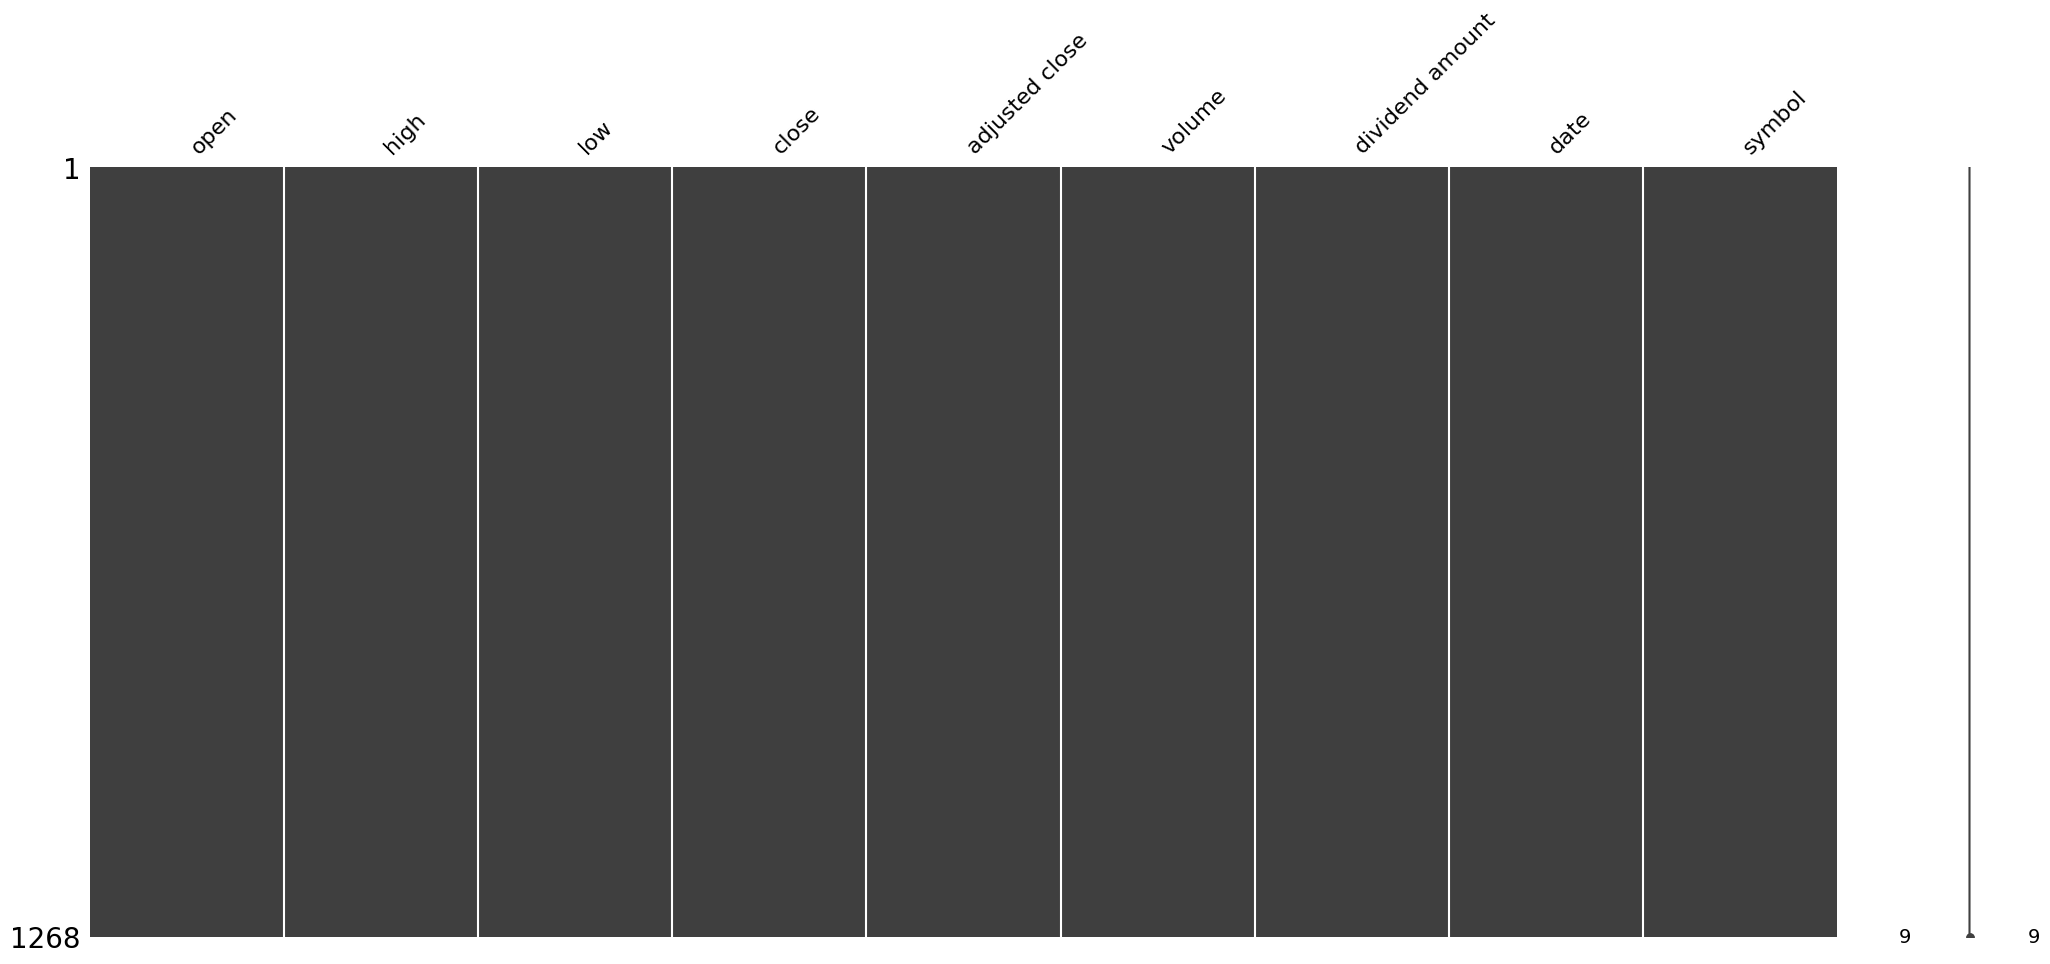

In [31]:
# Revisamos visualmente la existencia de datos faltantes
msno.matrix(result_df)

In [32]:
# Revisamos los tipos de datos de cada columna para posteriormente crear la tabla en la base de datos con ellos
result_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1268 entries, 0 to 1267
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   open             1268 non-null   float64       
 1   high             1268 non-null   float64       
 2   low              1268 non-null   float64       
 3   close            1268 non-null   float64       
 4   adjusted close   1268 non-null   float64       
 5   volume           1268 non-null   int32         
 6   dividend amount  1268 non-null   float64       
 7   date             1268 non-null   datetime64[ns]
 8   symbol           1268 non-null   object        
dtypes: datetime64[ns](1), float64(6), int32(1), object(1)
memory usage: 84.3+ KB


In [33]:
# Se buscan las medidas de tendencia central y dispersión de las columnas numéricas para revisar que no haya datos atípicos
result_df.describe()

,open,high,low,close,adjusted close,volume,dividend amount,date
count,1268.000000,1268.000000,1268.000000,1268.000000,1268.000000,1268.000000,1268.000000,1268
mean,326.031775,348.203109,302.617583,325.391417,58.585050,456.354101,0.117800,2012-08-10 08:37:51.293375488
min,5.910000,9.190000,5.510000,5.970000,0.214300,12.000000,0.000000,1999-12-31 00:00:00
25%,55.007500,60.630000,49.305000,55.220000,13.872400,97.000000,0.000000,2006-07-31 00:00:00
50%,123.210000,131.380000,116.040000,123.340000,38.978100,189.500000,0.000000,2013-02-28 00:00:00
75%,228.065000,241.447500,205.610000,226.212500,98.673200,681.000000,0.000000,2018-08-31 00:00:00
max,3545.000000,3773.078200,3306.980000,3507.070000,352.800000,3887.000000,3.290000,2023-11-03 00:00:00
std,599.861050,640.196745,556.303771,597.888069,61.642059,507.593599,0.379837,NaN


In [34]:
# Revisamos la cantidad de valores por símbolo
# Se evidencia menos datos para Google
result_df['symbol'].value_counts().sort_values(ascending=False)

symbol
AAPL    288
AMZN    288
IBM     288
MSFT    288
GOOG    116
Name: count, dtype: int64

# Creación de tabla en redshift (parte de la entrega 1)

In [35]:
# Se utiliza la misma funcion de creacion de tabla de la entrega anterior
def crear_tabla_redshift(nombre_tabla):
    try:
        # Se crea la tabla en Redshift con el nombre de la acción de la entrega anterior
        cursor = conn.cursor()
        # Se elimina la tabla si ya existe
        cursor.execute(f"DROP TABLE IF EXISTS {nombre_tabla};")
        # Se determinan los tipos de dato a partir de el .info anterior
        cursor.execute(f"""CREATE TABLE IF NOT EXISTS {nombre_tabla} ("open" FLOAT, "high" FLOAT, "low" FLOAT, "close" FLOAT, "adjusted close" FLOAT, "volume" INT, "dividend amount" FLOAT, "date" TIMESTAMP, "symbol" VARCHAR(255));
        """)
        conn.commit()
        cursor.close()
        print("Tabla creada exitosamente")
    except Exception as e:
        print("Error creating table")
        print(e)

In [36]:
# Se crea la tabla en Redshift para cada todas las acciones de distintos Symbol
crear_tabla_redshift('monthly_stocks_over_time')

Tabla creada exitosamente


# Carga de datos en la tabla de redshift

In [37]:
def cargar_en_redshift(conn, table_name, dataframe):
    # Funcion para cargar un dataframe en una tabla de redshift, creando la tabla si no existe
    # Definir formato tipos de datos SQL
    dtypes = dataframe.dtypes
    cols = list(dtypes.index)
    print(cols)
    tipos = list(dtypes.values)
    type_map = {
        'float64': 'FLOAT',
        'int32': 'INT',
        'datetime64[ns]': 'TIMESTAMP',
        'object': 'VARCHAR(255)'
    }
    # Definir formato TIPO_DATO revisando el tipo de dato de cada columna del dataframe
    sql_dtypes = [type_map.get(str(dtype), 'VARCHAR(255)') for dtype in tipos]

    # Definir formato COLUMNA TIPO_DATO
    column_defs = [f'"{name}" {data_type}' for name, data_type in zip(cols, sql_dtypes)]

    # Combina las columnas y los tipos de datos en una sola cadena de SQL para crear la tabla con todas la columnas necesarias
    # En este caso del ejercicio creamos la tabla anteriormente por lo que no es necesario volver a crearla y mas adelante solo se insertan los datos.
    table_schema = f"""
        CREATE TABLE IF NOT EXISTS {table_name} ({', '.join(column_defs)});
        """
    print(table_schema)

    # Crear la tabla
    cur = conn.cursor()
    try:
        # Se ejecuta el comando para crear la tabla creado anteriormente
        cur.execute(table_schema)

        # Generar los valores a insertar
        values = [tuple(x) for x in dataframe.values]

        # Definir el INSERT con las columnas a insertar
        insert_sql = f"INSERT INTO {table_name} (\"open\", \"high\", \"low\", \"close\", \"adjusted close\", \"volume\", \"dividend amount\", \"date\", \"symbol\") VALUES %s"

        # Execute the transaction to insert the data
        cur.execute("BEGIN")
        execute_values(cur, insert_sql, values)
        cur.execute("COMMIT")
        print('Proceso terminado')
    except Exception as e:
        print(f"Error: {e}")
        conn.rollback()  # Rollback the transaction on error

In [38]:
# Se carga el DataFrame en la tabla de Redshift
cargar_en_redshift(conn=conn, table_name='monthly_stocks_over_time', dataframe=result_df)

['open', 'high', 'low', 'close', 'adjusted close', 'volume', 'dividend amount', 'date', 'symbol']

        CREATE TABLE IF NOT EXISTS monthly_stocks_over_time ("open" FLOAT, "high" FLOAT, "low" FLOAT, "close" FLOAT, "adjusted close" FLOAT, "volume" INT, "dividend amount" FLOAT, "date" TIMESTAMP, "symbol" VARCHAR(255));
        
Proceso terminado
